# MDOF PINN - instance prediction

## Problem overview

The example problem we solve here is the 3DOF nonlinear-stiffness oscillator defined in state space:
$$
\dot{\mathbf{z}} = \mathbf{A}\mathbf{z} + \mathbf{A}_n\mathbf{z}_n + \mathbf{H}\mathbf{f}
$$
$$
\mathbf{y} = \ddot{\mathbf{x}} = \mathbf{B}\mathbf{z} + \mathbf{B}_n\mathbf{z}_n + \mathbf{D}\mathbf{f}
$$
where,
$$
\mathbf{z} = \left\{ x_1, x_2, ... , x_n, \dot{x}_1, \dot{x}_2, ... , \dot{x}_n \right\}^T, \quad
\mathbf{f} = \left\{ f_1, f_2, ... , f_n \right\}^T
$$
and $\mathbf{z}_n$ is the nonlinear state vector.
$$
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{A}_n = \begin{bmatrix} 0 \\ -\mathbf{M}^{-1} \mathbf{K}_n \end{bmatrix}, \quad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
$$
\mathbf{B} = \begin{bmatrix} -\mathbf{S}_a\mathbf{M}^{-1}\mathbf{K} & -\mathbf{S}_a\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{B}_n = \begin{bmatrix} -\mathbf{S}_a\mathbf{M}^{-1} \mathbf{K}_n \end{bmatrix}, \quad
\mathbf{D} = \begin{bmatrix} \mathbf{S}_f\mathbf{M}^{-1} \end{bmatrix}
$$
where $\mathbf{S}_a$ is the sensor location vector, i.e. if DOFs 2 and 4 are unobserved;
$$
\mathbf{S}_a = \textrm{diag}\left(\begin{bmatrix} 1 & 0 & 1 & 0 & 1 \end{bmatrix}\right)
$$
with the initial conditions
$$
\mathbf{x}(0) = \mathbf{x}_0~~,~~\dot{\mathbf{x}}(0) = \dot{\mathbf{x}}_0
$$

or with observed states
$$
\mathbf{y} = \{\mathbf{x}; \ddot{\mathbf{x}}\} = \mathbf{B}\mathbf{z} + \mathbf{B}_n\mathbf{z}_n + \mathbf{D}\mathbf{f}
$$
$$
\mathbf{B} = \begin{bmatrix} \mathbf{S}_d & 0 \\ 0 & \mathbf{S}_v \\ -\mathbf{S}_a\mathbf{M}^{-1}\mathbf{K} & -\mathbf{S}_a\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{B}_n = \begin{bmatrix} 0 \\ 0 \\ -\mathbf{S}_a\mathbf{M}^{-1} \mathbf{K}_n \end{bmatrix}, \quad
\mathbf{D} = \begin{bmatrix} 0 \\ 0 \\ \mathbf{S}_f\mathbf{M}^{-1} \end{bmatrix}
$$

In [ ]:
import sys
sys.path.append('../_mdofPINN/')
sys.path.append('../')

from pinnModels import mdof_pinn_model, gen_ndof_cantilever, mdof_dataset, nonlinearity
from pinnUtils import mdof_pinn_plotter, mdof_pinn_trainer, dropout, ParamClipper
from auxUtils import sparse_recov_parser, add_noise
import dynasim

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR, ConstantLR, SequentialLR

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

{'m_': array([10., 10., 10., 10., 10., 10.]), 'c_': array([1., 1., 1., 1., 1., 1.]), 'k_': array([15., 15., 15., 15., 15., 15.]), 'kn_': array([100., 100., 100., 100., 100., 100.]), 'cn_': array([0., 0., 0., 0., 0., 0.])}
{'m_': array([10., 10., 10., 10., 10., 10.]), 'c_': array([1., 1., 1., 1., 1., 1.]), 'k_': array([15., 15., 15., 15., 15., 15.]), 'kn_': array([100., 100., 100., 100., 100., 100.]), 'cn_': array([0., 0., 0., 0., 0., 0.])}


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/dynasim/base.py:188: UserWarning: No initial conditions provided, proceeding with zero initial state
  warnings.warn('No initial conditions provided, proceeding with zero initial state', UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


20240813__sr_exten_67dr_6dof_nonerr_10snr


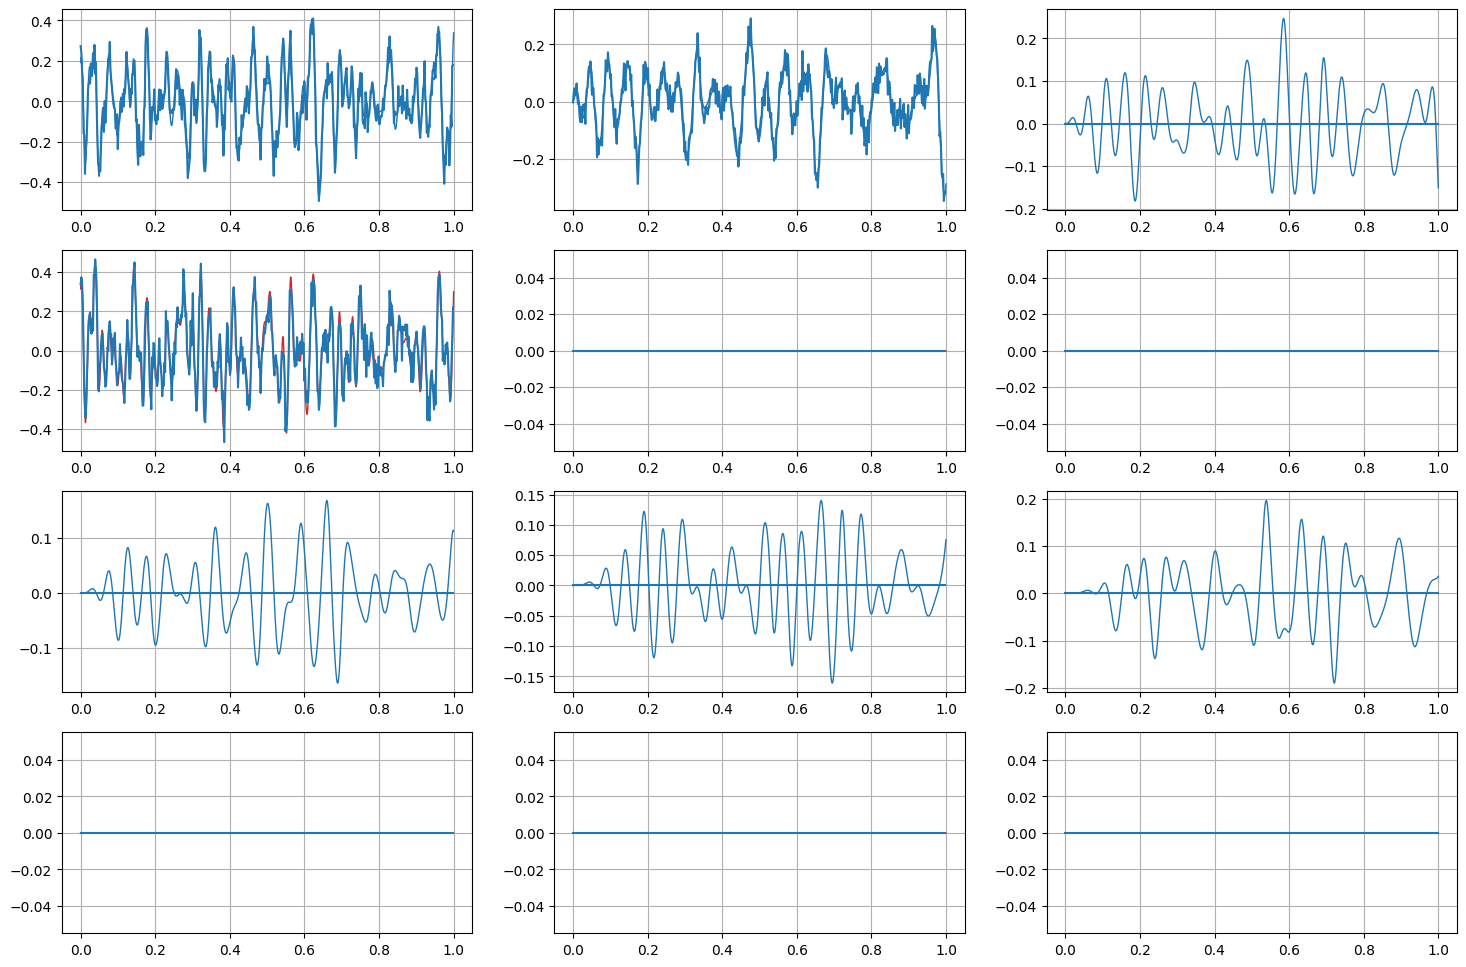

In [2]:
nt = 4096
time = np.linspace(0, 60, nt)

n_dof = 6

test_args = {
    'sparsity_type' : 'domain_extension',
    # 'sparsity_type' : 'domain_interpolation',
    # 'nonlin_type' : 'vanDerPol_damping',
    'nonlin_type' : 'duffing_stiffness',
    'error_type' : 'No error',
    'p_obs_drop' : 67.0,
    'snr' : 10.0,
    'dofs' : n_dof
}
parser = sparse_recov_parser(**test_args)

parser.update_date_id('20240813')

# set physical parameters
k1 = 15.0
c1 = 1.0
m1 = 10.0
kn_ = np.zeros((n_dof))
cn_ = np.zeros((n_dof))
if parser.nonlin_type == 'duffing_stiffness':
    for i in range(0, kn_.shape[0]):
        kn_[i] = 100.0
elif (parser.nonlin_type == 'vanDerPol_damping') | (parser.nonlin_type == 'exponent_damping'):
    for i in range(0, cn_.shape[0]):
        cn_[i] = 0.75

nom_params = {
    'm_' : np.ones((n_dof)) * m1,
    'c_' : np.ones((n_dof)) * c1,
    'k_' : np.ones((n_dof)) * k1,
    'kn_' : kn_.copy(),
    'cn_' : cn_.copy()
}

prescr_params, gt_params = parser.prescribe_params(nom_params, min_error = 0.05, max_error = 0.10)
print(prescr_params)
print(gt_params)

# create nonlinearity
match parser.nonlin_type:
    case 'vanDerPol_damping':
        system_nonlin = dynasim.nonlinearities.vanDerPol(cn_, dofs=n_dof)
    case 'exponent_damping':
        system_nonlin = dynasim.nonlinearities.exponent_damping(cn_, exponent=0.5, dofs=n_dof)
    case 'duffing_stiffness':
        system_nonlin = dynasim.nonlinearities.exponent_stiffness(kn_, exponent=3, dofs=n_dof)

# instantiate system
system = dynasim.systems.mdof_cantilever(gt_params['m_'], gt_params['c_'], gt_params['k_'], dofs=n_dof, nonlinearity=system_nonlin)
lin_system = dynasim.systems.mdof_cantilever(gt_params['m_'], gt_params['c_'], gt_params['k_'], dofs=n_dof, nonlinearity=None)

excitations = [None] * n_dof
excitations[0] = dynasim.actuators.banded_noise([0.05, 1.0], amplitude = 5.0e2)

# excitations = [dynasim.actuators.banded_noise([0.05, 1.0], amplitude = 5.0e2)] * n_dof

system.excitations = excitations
lin_system.excitations = excitations

data = system.simulate(time, z0=None)
lin_solution = lin_system.simulate(time, z0=None)

t_span = torch.tensor(time.reshape(-1,1), dtype=torch.float32)
xx, vv, aa = data['x'].T, data['xdot'].T, data['acc'].T  # get displacement, velocity, acceleration

# get acceleration

f = system.f.T
xx_noisy = torch.tensor(add_noise(xx, SNR = parser.snr, seed=43810), dtype=torch.float32)
vv_noisy = torch.tensor(add_noise(vv, SNR = parser.snr, seed=13927), dtype=torch.float32)
aa_noisy = torch.tensor(add_noise(aa, SNR = parser.snr, seed=2024), dtype=torch.float32)
f_noisy = torch.tensor(add_noise(f, SNR = parser.snr, seed=1234), dtype=torch.float32)

dropouts = parser.dropouts

xx_noisy, vv_noisy, aa_noisy, f_noisy = dropout(dropouts, xx_noisy, vv_noisy, aa_noisy, f_noisy)

ground_truth = {
    "t" : time.reshape(-1,1),
    "x_hat" : xx,
    "v_hat" : vv,
    "a_hat" : aa,
    "f_hat" : f,
    'params' : gt_params
}

device = torch.device("cpu")
batch_size = int(nt/8)
data_config = {
    'batch_size' : batch_size,
    'subsample' : 8,
    'seq_len' : 1
}
if test_args['error_type'] == 'Force missing':
    dataset = mdof_dataset(t_span, aa_noisy, f_noisy, data_config = data_config, device=device, force_drop=True)
else:
    dataset = mdof_dataset(t_span, aa_noisy, f_noisy, data_config = data_config, device=device)
phases = ['full', 'train', 'val']
full_dataset = torch.utils.data.random_split(dataset, [1.0])
train_size = 1.0; val_size = 0.0
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)#, multiprocessing_context='fork')

if n_dof > 3:
    sub_rows = n_dof // 3 + int((n_dof%3)!=0)
    sub_cols = 3
else:
    sub_rows = 1
    sub_cols = n_dof

fig, axs = plt.subplots(2*sub_rows, sub_cols,figsize=(6*sub_cols, 6*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        axs[j*2, i].plot(ground_truth['t'][:,0]/dataset.alphas['t'], ground_truth['a_hat'][:, p_count]/dataset.alphas['a'], color="tab:blue", linewidth=1.0, linestyle='-')
        for a in range(data_config['seq_len']):
            axs[j*2, i].plot(dataset.obs_data[:, a, -1].cpu(), dataset.obs_data[:, a, p_count].cpu())
        axs[j*2, i].grid()

        axs[j*2+1, i].plot(ground_truth['t'][:,0]/dataset.alphas['t'], ground_truth['f_hat'][:, p_count]/dataset.alphas['f'], color="tab:red", linewidth=1.0, linestyle='-')
        for a in range(data_config['seq_len']):
            axs[j*2+1, i].plot(dataset.obs_data[:, a, -1].cpu(), dataset.obs_data[:, a, p_count+n_dof].cpu())
        axs[j*2+1, i].grid()

        p_count += 1
        if p_count == n_dof:
            break 

print(parser.file_id)

## PINN

Neural network predicts over the full time domain:
$$
\mathcal{N}_{\mathbf{z}}(t), \qquad 
\mathbf{R} = \partial_t \mathcal{N}_{\mathbf{z}} - \mathbf{A} \mathcal{N}_{\mathbf{z}} - \mathbf{A}_n \mathcal{N}_{\mathbf{z}_n} - \mathbf{H}\mathbf{f}
$$

$$
\mathcal{L}(t;\mathbf{\theta}) := \mathcal{L}_{obs} + \mathcal{L}_{ic} + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{obs} = \langle \hat{\mathbf{z}}^* - \mathcal{N}_{\hat{\mathbf{z}}} \rangle _{\Omega_o}
% \mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}} \mathcal{N}_{\hat{x}_j} \right\rangle _{\Omega_d}
$$
<!-- $$
\mathcal{L}_{ic} = \sum_{j=1}^{N_{d}}\left[ 
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{x}\hat{x}_{j,0} - \alpha_x\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} \right\rangle
\right] _{\Omega\in\{t=0\}}
$$ -->
$$
\mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[j,:] \right\rangle _{\Omega_p}, \qquad
\mathcal{L}_{ode} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[N_d+j,:] \right\rangle _{\Omega_p}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{z};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{t\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

In [ ]:
alphas = {
    "x" : torch.tensor(1.0, dtype=torch.float32),
    "v" : torch.tensor(1.0, dtype=torch.float32),
    "c" : torch.tensor(1.0, dtype=torch.float32),
    "k" : torch.tensor(1.0, dtype=torch.float32),
    "kn" : torch.tensor(1.0, dtype=torch.float32),
    "cn" : torch.tensor(1.0, dtype=torch.float32)
}
alphas.update(dataset.alphas)

torch.manual_seed(123)

pinn_config = {
    "n_input" : 1,
    "n_output" : 2*n_dof,
    "n_hidden" : 256,
    "n_layers" : 4,
    "seq_len" : data_config['seq_len'],
    "n_dof" : n_dof,
    "phys_params" : parser.pinn_param_dict(prescr_params),
    # "activation" : "Tanh",
    "alphas" : alphas,
    "device" : device,
    'lambds' : {
        'obs' : 1.0,
        'occ' : 0.0,
        'ode' : 100.0,
        'cc' : 10.0
    },
    'dropouts' : dropouts,
    'acc_obs_method' : 'both',
    # 'net_split' : True
}

if parser.error_type == 'Linear model':
    pinn_nonlinearity = None
else:
    match parser.nonlin_type:
        case 'exponent_damping':
            pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 0.5)
        case 'vanDerPol_damping':
            pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 'vdp')
        case 'duffing_stiffness':
            pinn_nonlinearity = nonlinearity(n_dof, gk_exp = 3, gc_exp = None)

# configure PINN
mdof_model = mdof_pinn_model(pinn_config)
mdof_model.configure(gen_ndof_cantilever, pinn_nonlinearity)

# configure optimiser
betas = (0.99, 0.999)
# network_optimizer = torch.optim.Adam(mdof_model.network_parameters, lr=1e-3, betas=betas, weight_decay=1e-5)
net_optimisers = [torch.optim.Adam(mdof_model.net_params_list[n], lr=1e-3, betas=betas, weight_decay=1e-5) for n in range(data_config['seq_len'])]

print_step = 500

plotter = mdof_pinn_plotter(n_dof, n_cols = 3, figsize=(18,16))
trainer = mdof_pinn_trainer(train_dataset, data_config, n_dof, device, train_loader, col_domain=False)

trainer.train(num_epochs = int(2e5), 
              mdof_model = mdof_model, 
              print_step = print_step, 
              net_optimisers = net_optimisers, 
              plotter = plotter,
              ground_truth = ground_truth, 
              pinn_config = pinn_config
              )

In [5]:
checkpoint = {
    # auxiliary information
    'alphas' : alphas,
    'test_args' : test_args,  # test arguments
    'true_params' : gt_params,  # true system parameters,
    'dropouts': dropouts,
    'prescribed_params' : prescr_params,  # prescribed system parameters
    'pinn_config' : pinn_config,  # PINN configuration
    # training information
    'epoch' : i,
    'loss' : trainer.loss_hist,  # loss history
    # model checkpoint information
    'model' : mdof_model.state_dict(),  # overall model state for system parameters
    'models' : [net.state_dict() for net in mdof_model.nets],  # individual model states for each network
    'net_optimisers_dict' : [net_optim.state_dict() for net_optim in net_optimisers],  # individual optimiser states for each network
    # 'param_optimiser' : param_optimiser.state_dict(),  # overall optimiser state for system parameters
}
torch.save(checkpoint, f'checkpoints/{parser.file_id}.pth')

Epoch 199999
	Loss 1.0491e-02



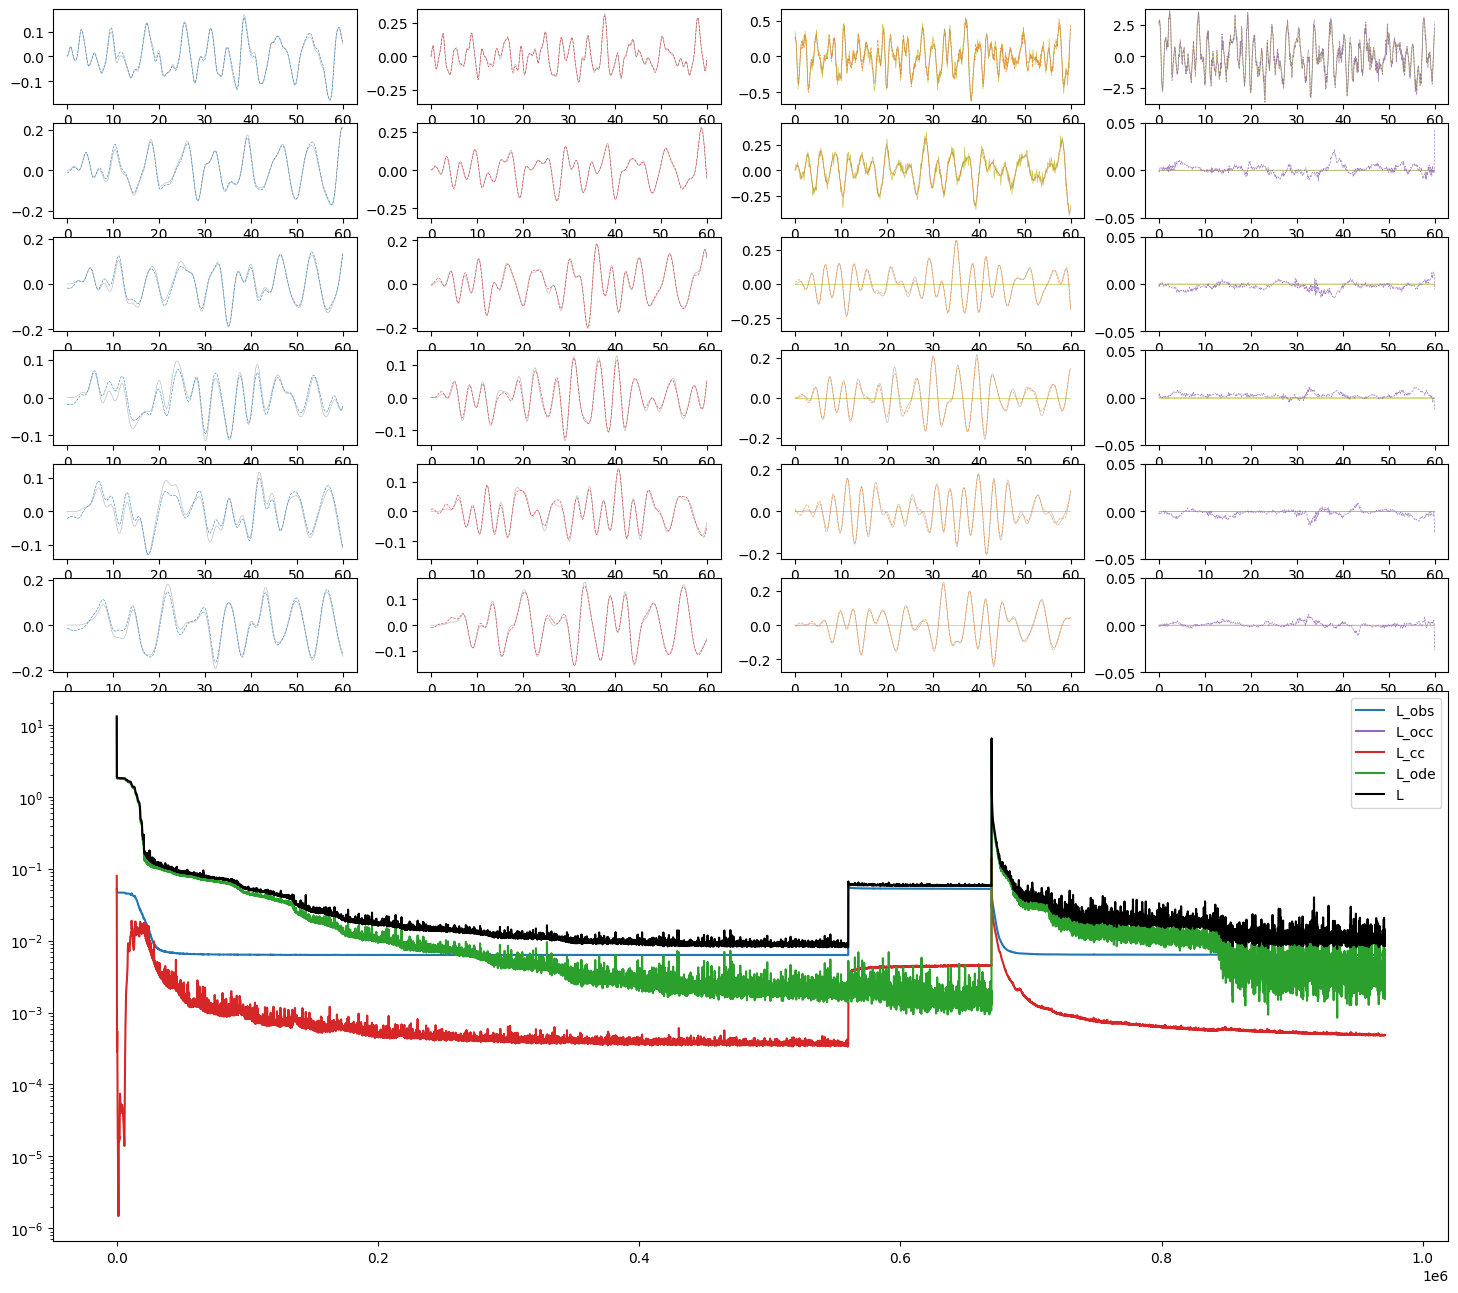

In [4]:
checkpoint = torch.load(f'checkpoints/{parser.file_id}.pth')
loss_hist = checkpoint["loss"]
mdof_model.load_state_dict(checkpoint['model'])
for i, net_model in enumerate(mdof_model.nets):
    net_model.load_state_dict(checkpoint['models'][i])
mdof_model.gather_params()

net_optimisers = [torch.optim.Adam(mdof_model.net_params_list[n], lr=1e-3, betas=betas, weight_decay=1e-5) for n in range(data_config['seq_len'])]
for net_optim, state_dict in zip(net_optimisers, checkpoint['net_optimisers_dict']): 
    net_optim.load_state_dict(state_dict)
    # for g in net_optim.param_groups:
    #     g['lr'] = 1e-3
    
num_epochs = int(2e5)
switch_epoch = int(2.5e4)
init_lr = 5e-4
gamma = 0.99995
factor = init_lr * gamma ** switch_epoch
net_lr_schedulers = [SequentialLR(
    net_optimisers[i],
    schedulers = [
        ExponentialLR(net_optimisers[i], gamma=gamma),
        ConstantLR(net_optimisers[i], factor=factor, total_iters=num_epochs-switch_epoch),
    ],
    milestones = [switch_epoch]
) for i in range(data_config['seq_len'])]

pinn_config['lambds'] = {
    'obs' : 1.0,
    'occ' : 0.0,
    'ode' : 1000.0,
    'cc' : 10.0,
}
mdof_model.set_switches(pinn_config['lambds'])

print_step = 500

plotter = mdof_pinn_plotter(n_dof, n_cols = 3, figsize=(18,16))
trainer = mdof_pinn_trainer(train_dataset, data_config, n_dof, device, train_loader, col_domain=False)

display.clear_output()

trainer.train(num_epochs = num_epochs, 
              mdof_model = mdof_model, 
              print_step = print_step, 
              net_optimisers = net_optimisers, 
              plotter = plotter,
              ground_truth = ground_truth,
              loss_hist = loss_hist,
              pinn_config = pinn_config,
            #   schedulers = net_lr_schedulers
              )

In [6]:
prediction = trainer.prediction

result_data = {
    # auxiliary information
    'alphas' : alphas,
    'test_args' : test_args,  # test arguments
    'true_params' : gt_params,  # true system parameters
    'prescribed_params' : prescr_params,  # prescribed system parameters
    'pinn_config' : pinn_config,  # PINN configuration
    # training information
    'epoch' : i,
    'loss' : trainer.loss_hist,  # loss history
    # model checkpoint information
    'model' : mdof_model.state_dict(),  # overall model state for system parameters
    'models' : [net.state_dict() for net in mdof_model.nets],  # individual model states for each network
    # data for resulting
    'ground_truth' : ground_truth,
    'prediction' : prediction,
    'lin_solution' : lin_solution
}

torch.save(result_data, f'results/{parser.file_id}.pth')
print(f"Saved results to results/{parser.file_id}.pth")

Saved results to results/20240813__sr_exten_67dr_6dof_nonerr_10snr.pth
